In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
import warnings

warnings.filterwarnings('ignore')
df = pd.read_excel("Telco_customer_churn.xlsx")

In [2]:
# let's see how our target variable distributed
class_distribution = df['Churn Value'].value_counts(normalize=True) * 100
print("Class Distribution (%):")
print(class_distribution)

Class Distribution (%):
Churn Value
0    73.463013
1    26.536987
Name: proportion, dtype: float64


In [3]:
# as mentioned before, total charges column need to transformed from object to numerical
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

In [4]:
missing_values = df.isnull().sum()
print("Missing values:")
print(missing_values[missing_values > 0])
# most of the customers' churn value is 0, so they don't have churn reason
# it is sense, because if customer is not leaved, so he/she does not have to have churn reason

Missing values:
Total Charges      11
Churn Reason     5174
dtype: int64


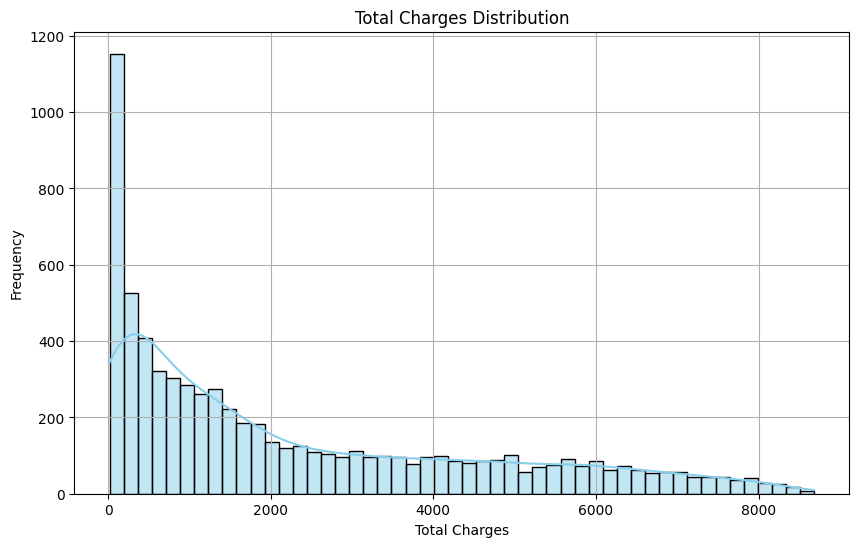

Skewness: 0.961642499724251


In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Total Charges'], kde=True, bins=50, color='skyblue')
plt.title('Total Charges Distribution')
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Skewness value
print("Skewness:", df['Total Charges'].skew())

In [6]:
df['Total Charges'] = df['Total Charges'].fillna(df['Total Charges'].median()) # Fill with median (since it’s numerical and skewed)

In [7]:
# Drop irrelevant columns
df = df.drop(columns=[
    'CustomerID',       # Unique identifier
    'Churn Label',      # Duplicate of Churn Value, cause misinterpretation of models, causes data leakage
    'Country',          # Single value (all US)
    'Lat Long',         # Redundant with Latitude/Longitude
    'Count',            # redundant utility
    'Zip Code',         # High cardinality
    'City',             # High cardinality
    'State',            # Redundant with geographical coordinates
    'Churn Reason'      # we have to remove it because it cause misinterpretation of models, causes data leakeage
])

# Binary encoding (Yes/No to 1/0)
binary_cols = [
    'Partner', 'Dependents', 'Phone Service', 'Paperless Billing',
    'Senior Citizen'
]
df[binary_cols] = df[binary_cols].replace({'Yes': 1, 'No': 0})

# Ordinal encoding for Contract
contract_map = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df['Contract'] = df['Contract'].map(contract_map)

# One-hot encoding for nominal categorical features
nominal_cols = [
    'Gender', 'Multiple Lines', 'Internet Service', 'Online Security',
    'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
    'Streaming Movies', 'Payment Method'
]
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

# Normalize numerical features
numerical_cols = [
    'Tenure Months', 'Monthly Charges', 'Total Charges',
    'Churn Score', 'CLTV', 'Latitude', 'Longitude'
]
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [8]:
X = df.drop('Churn Value', axis=1)
y = df['Churn Value']
# split dataset into training set and test set.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
# score metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

# cross validation structure, k fold with k=5
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Helper function for testing of evaluated model
def evaluate_model(model, X, y, model_name):
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    return {
        'Mean F1': np.mean(scores['test_f1']),
        'Std F1': np.std(scores['test_f1']),
        'accuracy': np.mean(scores['test_accuracy']),
        'precision': np.mean(scores['test_precision']),
        'recall': np.mean(scores['test_recall'])
    }

# holds each model's results
results = {}

# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
results["Logistic Regression"] = evaluate_model(lr, X_train, y_train, "Logistic Regression")

# Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
results["Random Forest"] = evaluate_model(rf, X_train, y_train, "Random Forest")

# XGBoost
xgb = XGBClassifier(scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train), 
                    eval_metric='aucpr', random_state=42)
results["XGBoost"] = evaluate_model(xgb, X_train, y_train, "XGBoost")

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
results["Gradient Boosting"] = evaluate_model(gb, X_train, y_train, "Gradient Boosting")

# SVM
svm = SVC(class_weight='balanced', probability=True, random_state=42)
results["SVM"] = evaluate_model(svm, X_train, y_train, "SVM")

# KNN
knn = KNeighborsClassifier()
results["KNN"] = evaluate_model(knn, X_train, y_train, "KNN")

# result dataframe
results_df = pd.DataFrame(results).T.sort_values("Mean F1", ascending=False)

print("\n📈 Final Model Comparison:")
print(results_df)


📈 Final Model Comparison:
                      Mean F1    Std F1  accuracy  precision    recall
Gradient Boosting    0.868528  0.016540  0.930246   0.869988  0.867559
XGBoost              0.864545  0.016106  0.926696   0.849841  0.880268
Random Forest        0.861203  0.018144  0.926696   0.866594  0.856187
Logistic Regression  0.841908  0.017402  0.908061   0.775591  0.921070
SVM                  0.838998  0.019585  0.905753   0.769513  0.923077
KNN                  0.792615  0.016463  0.887825   0.779474  0.806689


In [10]:
# selected model is Gradient Boosting, because it gives the highest accuracy
# HyperParameter range
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

gb = GradientBoostingClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# best hyperparameters
print("\n🔍 Best Hyperparameters:")
print(grid_search.best_params_)

print("\n✅ Best F1 Score on CV:")
print(grid_search.best_score_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits

🔍 Best Hyperparameters:
{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}

✅ Best F1 Score on CV:
0.8766596104377176


In [11]:
# Choose best gradient boosting model
best_gb = grid_search.best_estimator_

# predict on test set
y_pred = best_gb.predict(X_test)

# best gradient boosting hyperparameters
best_gb

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, n_estimators=300,
                           random_state=42)

In [12]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9269
Precision: 0.8448
Recall: 0.8877
F1 Score: 0.8657


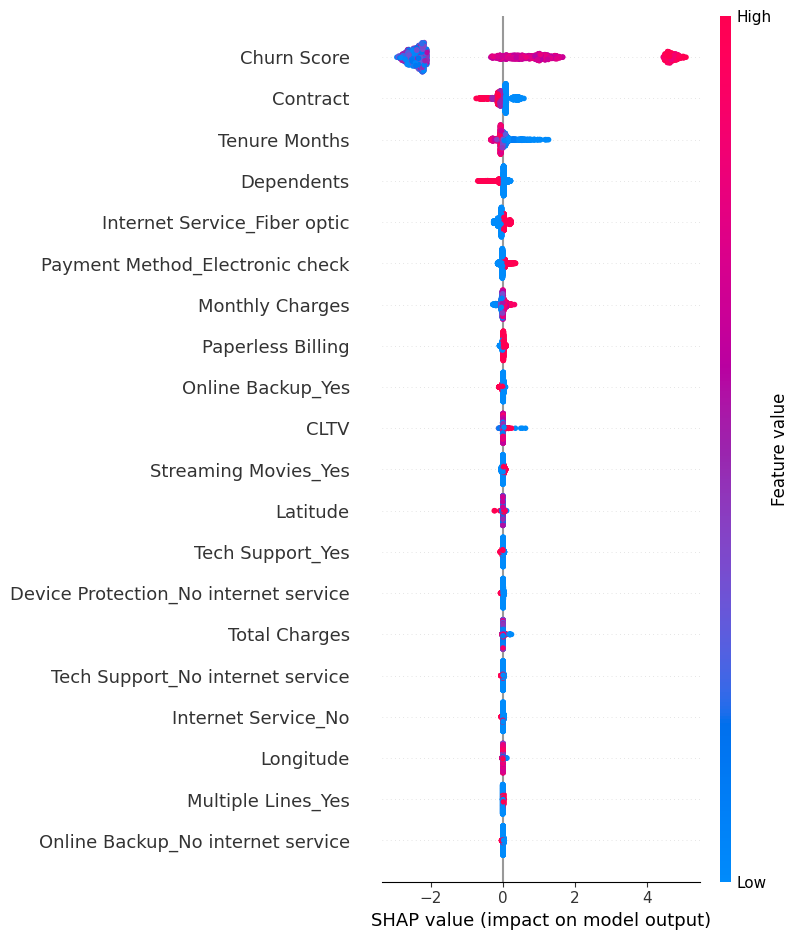

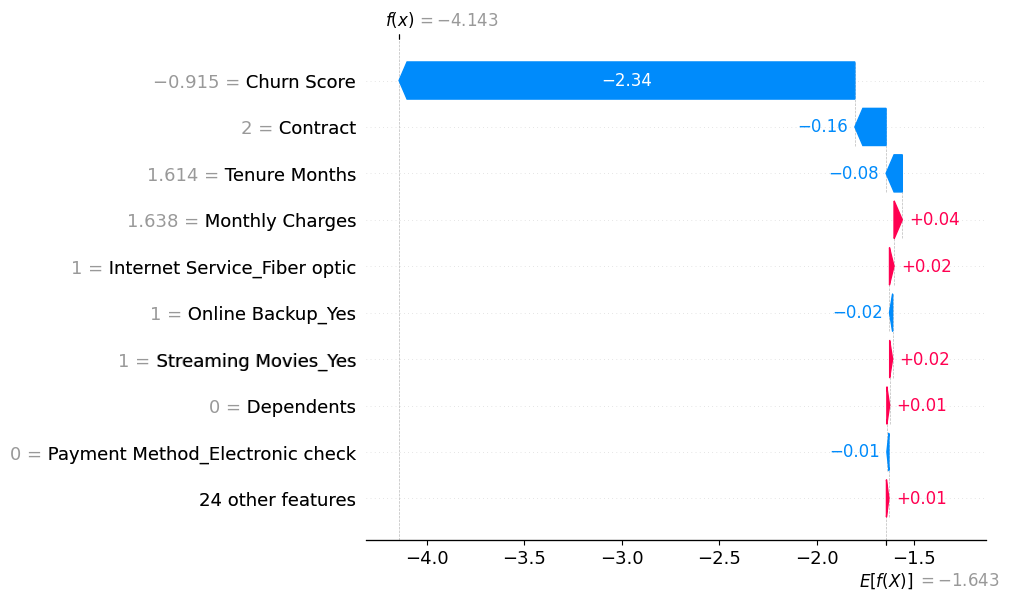

In [13]:
import shap
X_train_shap = X_train.copy()
X_test_shap = X_test.copy()

X_train_shap = X_train_shap.apply(pd.to_numeric, errors='coerce')
X_test_shap = X_test_shap.apply(pd.to_numeric, errors='coerce')
X_train_shap_fixed = X_train_shap.copy()
X_test_shap_fixed = X_test_shap.copy()
for col in X_train_shap_fixed.select_dtypes(include='bool').columns:
	X_train_shap_fixed[col] = X_train_shap_fixed[col].astype(int)
	X_test_shap_fixed[col] = X_test_shap_fixed[col].astype(int)

explainer = shap.Explainer(best_gb, X_train_shap_fixed)
shap_values = explainer(X_test_shap_fixed)

shap.summary_plot(shap_values, X_test_shap_fixed)
shap.plots.waterfall(shap_values[0])


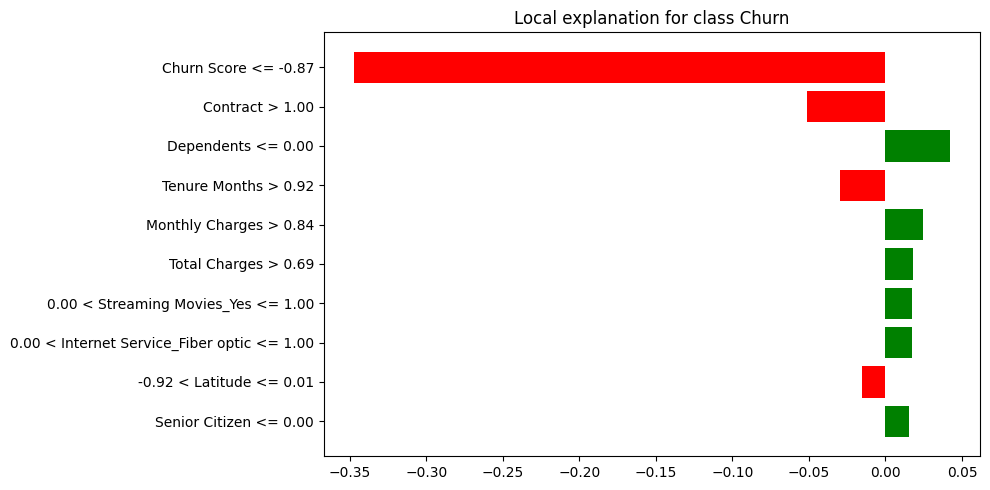

In [14]:
import lime
import lime.lime_tabular
from IPython.display import display

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_shap_fixed.values,
    feature_names=X_train_shap_fixed.columns.tolist(),
    class_names=["No Churn", "Churn"],
    mode="classification"
)

sample_index = 0
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_shap_fixed.iloc[sample_index].values,
    predict_fn=best_gb.predict_proba,
    num_features=10
)

fig = lime_exp.as_pyplot_figure()
fig.set_size_inches(10, 5)
plt.tight_layout()
plt.show()



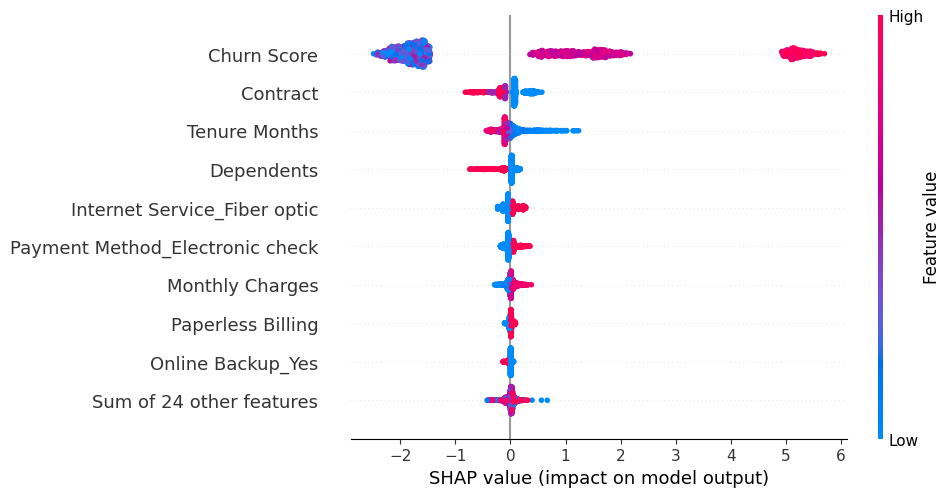

In [15]:
# 1. Kategorik sütunları one-hot encoding ile sayısallaştır
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# 2. Aynı sütunlara sahip olmaları için hizala
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# 3. float64 tipine çevir
X_train_encoded = X_train_encoded.astype(float)
X_test_encoded = X_test_encoded.astype(float)

# 4. SHAP açıklayıcı
import shap
explainer = shap.Explainer(best_gb, X_test_encoded)
shap_values = explainer(X_test_encoded)

# 5. Görselleştirme
shap.plots.beeswarm(shap_values)


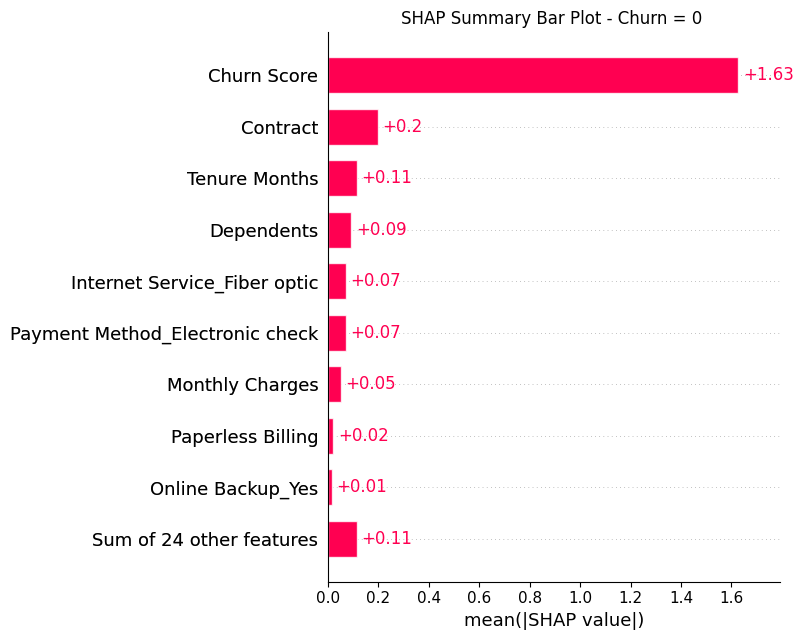

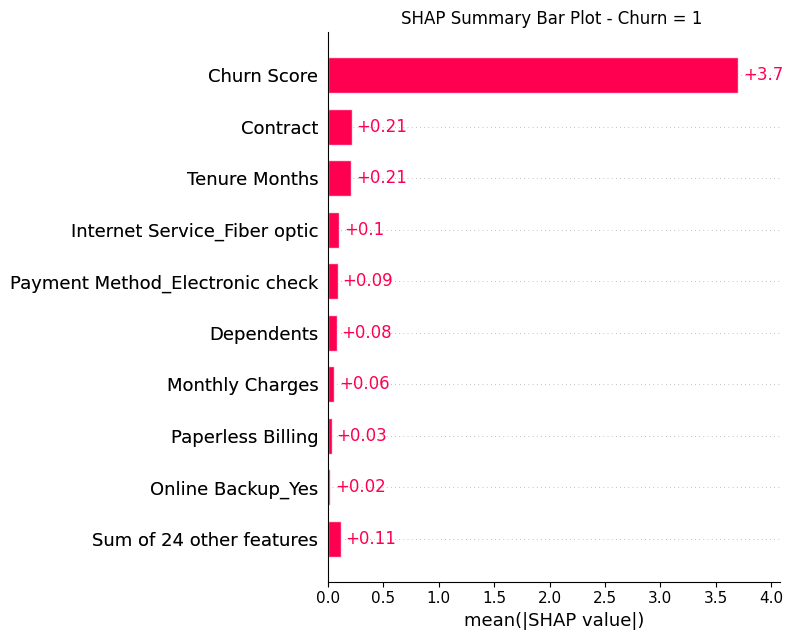

In [16]:
import shap
import matplotlib.pyplot as plt

# 1. Kategorik veriyi sayısallaştır (One-hot encoding)
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# 2. Test ve eğitim setindeki sütunları hizala, eksik sütunları 0 ile doldur
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# 3. Tipleri float64 yap (SHAP için gereklidir)
X_train_encoded = X_train_encoded.astype(float)
X_test_encoded = X_test_encoded.astype(float)

# 4. y_test'in index'ini X_test_encoded ile aynı yap (index uyumsuzluğunu önler)
y_test_aligned = y_test.copy()
y_test_aligned.index = X_test_encoded.index

# 5. Test verisini churn sınıfına göre ayır
X_test_class_0 = X_test_encoded[y_test_aligned == 0]
X_test_class_1 = X_test_encoded[y_test_aligned == 1]

# 6. SHAP açıklayıcıyı oluştur (best_gb modelinin daha önceden eğitildiğini varsayıyorum)
explainer = shap.Explainer(best_gb, X_test_encoded)

# 7. Her sınıf için SHAP değerlerini hesapla
shap_values_class_0 = explainer(X_test_class_0)
shap_values_class_1 = explainer(X_test_class_1)

# 8. Görselleştir: SHAP summary bar plot

plt.title("SHAP Summary Bar Plot - Churn = 0 ")
shap.plots.bar(shap_values_class_0, show=False)
plt.tight_layout()
plt.show()

plt.title("SHAP Summary Bar Plot - Churn = 1 ")
shap.plots.bar(shap_values_class_1, show=False)
plt.tight_layout()
plt.show()


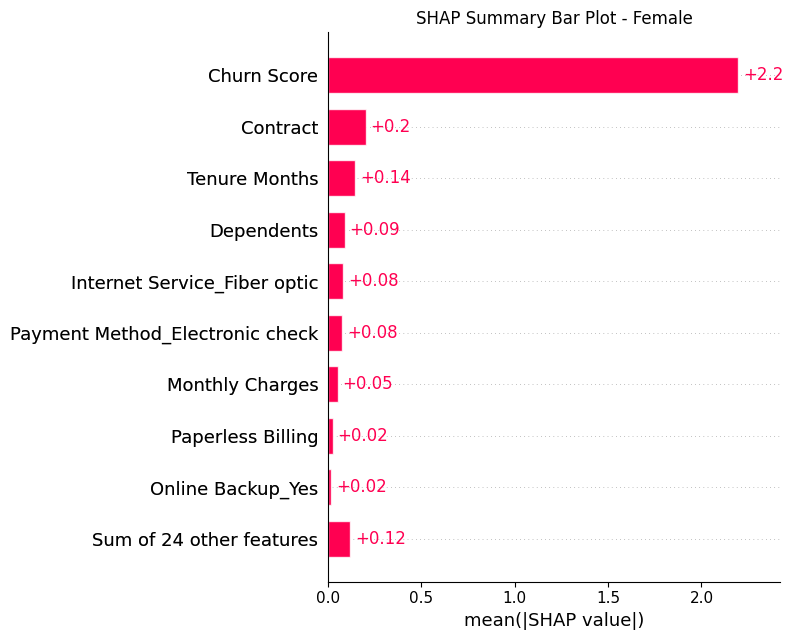

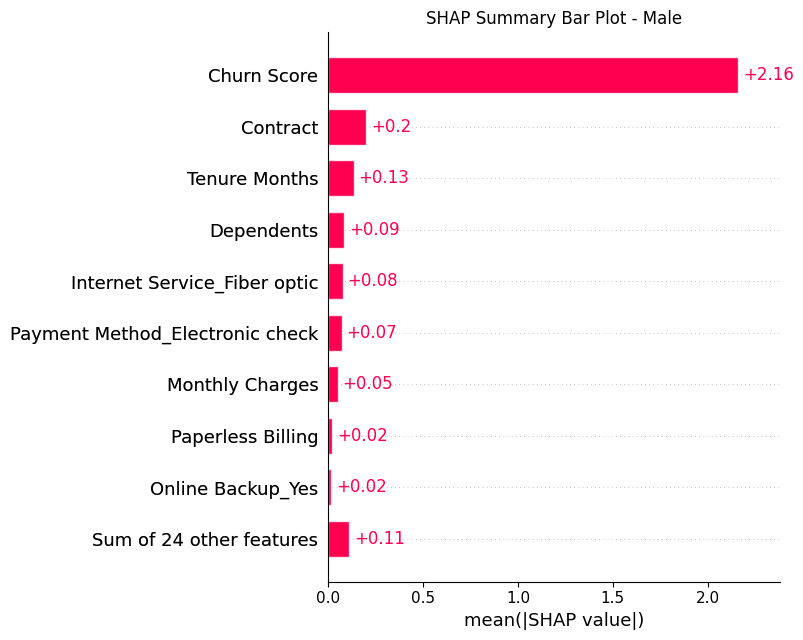

In [17]:
import shap
import matplotlib.pyplot as plt

# 1. Kategorik veriyi sayısallaştır (One-hot encoding)
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# 2. Test setindeki sütunları eğitim setine göre hizala, eksik sütunları 0 ile doldur
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# 3. Tipleri float64 yap (SHAP için)
X_train_encoded = X_train_encoded.astype(float)
X_test_encoded = X_test_encoded.astype(float)

# 4. y_test'in indexlerini X_test_encoded ile eşitle
y_test_aligned = y_test.copy()
y_test_aligned.index = X_test_encoded.index

# 5. Cinsiyete göre ayır: 'Gender_Male' sütunu var, '1' erkek, '0' kadın demek
X_test_female = X_test_encoded[X_test_encoded['Gender_Male'] == 0]
X_test_male = X_test_encoded[X_test_encoded['Gender_Male'] == 1]

# 6. SHAP açıklayıcıyı oluştur
explainer = shap.Explainer(best_gb, X_test_encoded)

# 7. Her grup için SHAP değerlerini hesapla
shap_values_female = explainer(X_test_female)
shap_values_male = explainer(X_test_male)

# 8. Görselleştir
plt.title("SHAP Summary Bar Plot - Female")
shap.plots.bar(shap_values_female, show=False)
plt.tight_layout()
plt.show()

plt.title("SHAP Summary Bar Plot - Male")
shap.plots.bar(shap_values_male, show=False)
plt.tight_layout()
plt.show()


In [18]:
print(X_test_encoded.columns)


Index(['Latitude', 'Longitude', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Contract', 'Paperless Billing',
       'Monthly Charges', 'Total Charges', 'Churn Score', 'CLTV',
       'Gender_Male', 'Multiple Lines_No phone service', 'Multiple Lines_Yes',
       'Internet Service_Fiber optic', 'Internet Service_No',
       'Online Security_No internet service', 'Online Security_Yes',
       'Online Backup_No internet service', 'Online Backup_Yes',
       'Device Protection_No internet service', 'Device Protection_Yes',
       'Tech Support_No internet service', 'Tech Support_Yes',
       'Streaming TV_No internet service', 'Streaming TV_Yes',
       'Streaming Movies_No internet service', 'Streaming Movies_Yes',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check', 'Payment Method_Mailed check'],
      dtype='object')


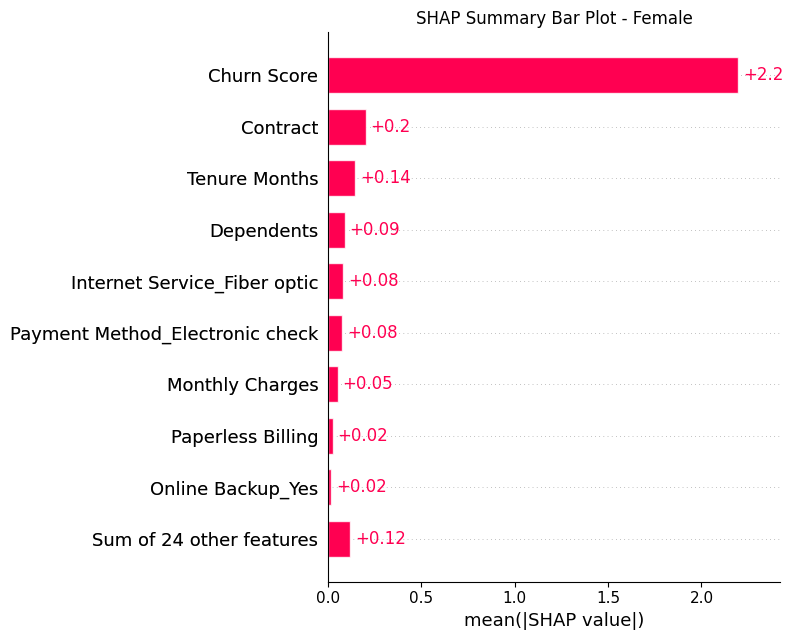

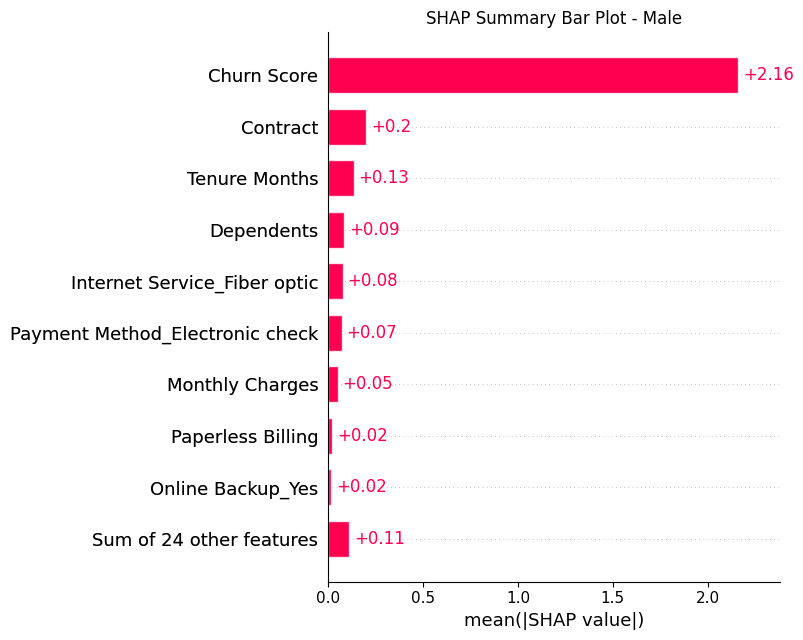

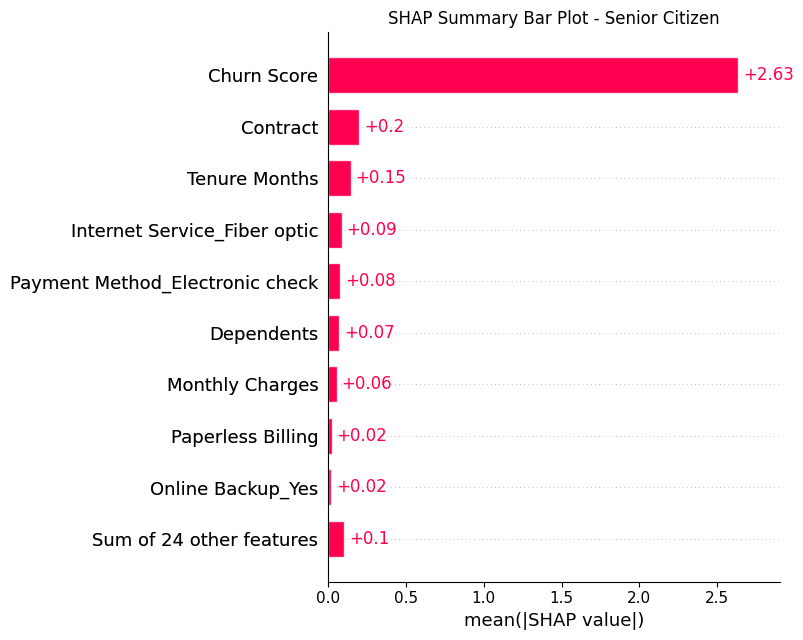

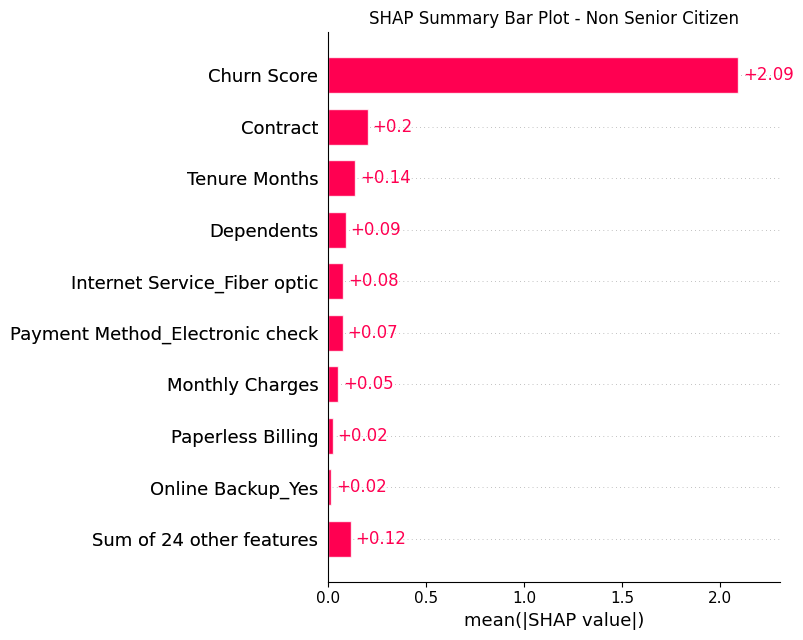

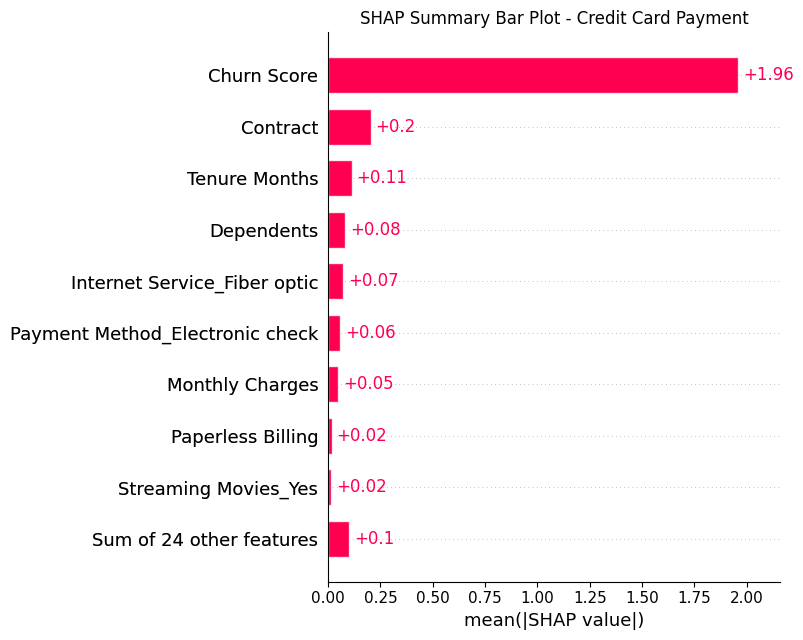

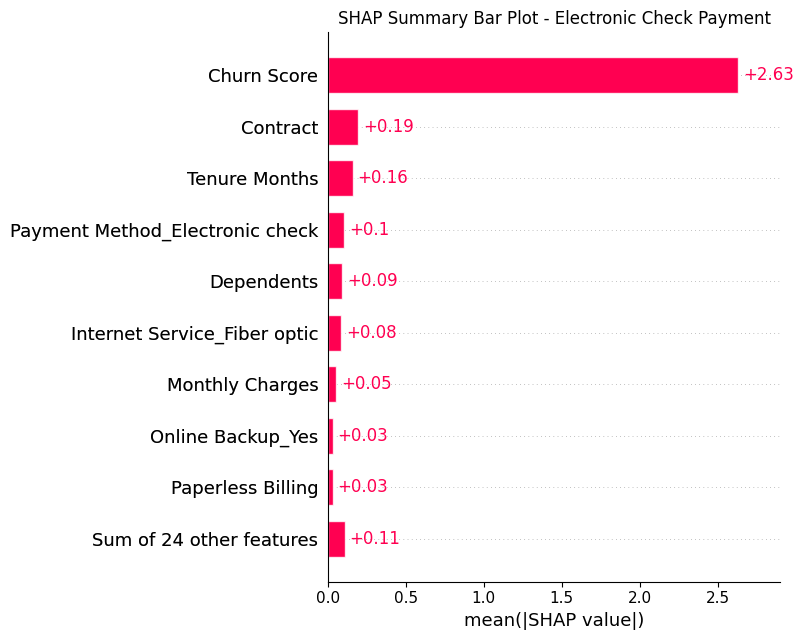

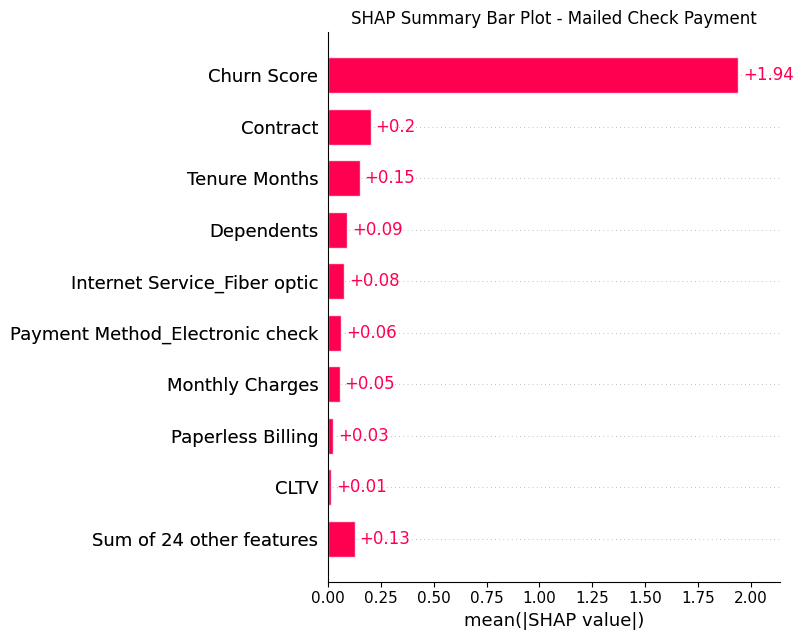

In [19]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# 1. Kategorik veriyi sayısallaştır (One-hot encoding)
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# 2. Test setini eğitim setine göre hizala, eksik sütunları 0 ile doldur
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# 3. Tipleri float64 yap (SHAP için gerekli)
X_train_encoded = X_train_encoded.astype(float)
X_test_encoded = X_test_encoded.astype(float)

# 4. Alt grupları oluştur
subgroups = {
    'Female': X_test_encoded[X_test_encoded['Gender_Male'] == 0],
    'Male': X_test_encoded[X_test_encoded['Gender_Male'] == 1],
    'Senior Citizen': X_test_encoded[X_test_encoded['Senior Citizen'] == 1],
    'Non Senior Citizen': X_test_encoded[X_test_encoded['Senior Citizen'] == 0],
    'Credit Card Payment': X_test_encoded[X_test_encoded['Payment Method_Credit card (automatic)'] == 1],
    'Electronic Check Payment': X_test_encoded[X_test_encoded['Payment Method_Electronic check'] == 1],
    'Mailed Check Payment': X_test_encoded[X_test_encoded['Payment Method_Mailed check'] == 1]
}

# 5. SHAP açıklayıcıyı oluştur
explainer = shap.Explainer(best_gb, X_test_encoded)

# 6. Her alt grup için SHAP değerlerini hesapla ve görselleştir
for group_name, group_data in subgroups.items():
    if len(group_data) == 0:
        print(f"Warning: {group_name} grubunda veri yok, atlanıyor.")
        continue

    shap_values = explainer(group_data)
    plt.title(f"SHAP Summary Bar Plot - {group_name}")
    shap.plots.bar(shap_values, show=False)
    plt.tight_layout()
    plt.show()
